## Final Project Submission

Please fill out:
* Student name: Phillip Ojo
* Student pace: Part time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


In [2]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

I will combine all the dataset into one large one since my target variable as indepent of specific car model.

In [3]:
df1 = pd.read_csv('opel_corsa_01.csv', delimiter= ';')
df2 = pd.read_csv('opel_corsa_02.csv', delimiter= ';')
df3 = pd.read_csv('peugeot_207_01.csv', delimiter= ';')
df4 = pd.read_csv('peugeot_207_02.csv', delimiter= ';')

In [4]:
all_dfs = [df1, df2, df3, df4]
car_data = pd.concat(all_dfs)

# Data

In [5]:
car_data

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage,roadSurface,traffic,drivingStyle
0,NaN,0,NaN,NaN,NaN,"0,0156","25,49019623",64.0,100.0,801,"7,849999905",22.0,"-0,0078",NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
1,NaN,0,NaN,NaN,NaN,"0,0156","25,49019623",64.0,100.0,803,"7,889999866",22.0,"-0,0156",NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
2,NaN,NaN,NaN,NaN,NaN,"0,0273","25,88235283",64.0,100.0,800,"7,769999981",22.0,"-0,0273",NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
3,NaN,NaN,NaN,NaN,NaN,"0,0391","25,88235283",64.0,100.0,798,"7,769999981",22.0,"-0,0273",NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
4,NaN,0,NaN,NaN,NaN,"0,0469","25,88235283",65.0,100.0,798,"7,940000057",22.0,"-0,0312",NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4618,1,"28,79999924","28,55999908","57,19057079","3,600000381","-0,0292","25,88235283",81.0,115.0,"1755,5","20,46999931",25.0,"-0,1661","14,57800293",SmoothCondition,LowCongestionCondition,EvenPaceStyle
4619,"1,699996948","30,59999847","28,5299991","57,01026584","1,799999237","-0,0304","11,76470566",81.0,106.0,"736,5","17,73999977",25.0,"-0,1987","14,58564186",SmoothCondition,LowCongestionCondition,EvenPaceStyle
4620,"1,800003052","29,69999886","28,49999908","56,8830454","-0,899999619","-0,1684","98,03921509",81.0,106.0,1254,"9,520000458",24.0,"-0,1156","14,54729366",SmoothCondition,LowCongestionCondition,EvenPaceStyle
4621,"2,100006104","29,69999886","28,40999908","56,16090993",0,"-0,0644","79,60784149",80.0,112.0,1254,"14,90999985",23.0,"-0,076","14,54682827",SmoothCondition,LowCongestionCondition,EvenPaceStyle


In [6]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24957 entries, 0 to 4622
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AltitudeVariation          24777 non-null  object 
 1   VehicleSpeedInstantaneous  24913 non-null  object 
 2   VehicleSpeedAverage        23775 non-null  object 
 3   VehicleSpeedVariance       23775 non-null  object 
 4   VehicleSpeedVariation      24769 non-null  object 
 5   LongitudinalAcceleration   24957 non-null  object 
 6   EngineLoad                 24952 non-null  object 
 7   EngineCoolantTemperature   24952 non-null  float64
 8   ManifoldAbsolutePressure   24952 non-null  float64
 9   EngineRPM                  24952 non-null  object 
 10  MassAirFlow                24952 non-null  object 
 11  IntakeAirTemperature       24952 non-null  float64
 12  VerticalAcceleration       24957 non-null  object 
 13  FuelConsumptionAverage     24671 non-null  obje

In [7]:
car_data['drivingStyle'].value_counts()

EvenPaceStyle      22089
AggressiveStyle     2868
Name: drivingStyle, dtype: int64

Changing the values from objets to floats


In [8]:
car_data[car_data.columns[:-3]] = car_data[car_data.columns[:-3]].replace(',','.',regex=True).astype(float)
car_data.head()

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage,roadSurface,traffic,drivingStyle
0,NaN,0.0,NaN,NaN,NaN,0.0156,25.490196,64.0,100.0,801.0,7.85,22.0,-0.0078,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
1,NaN,0.0,NaN,NaN,NaN,0.0156,25.490196,64.0,100.0,803.0,7.89,22.0,-0.0156,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
2,NaN,NaN,NaN,NaN,NaN,0.0273,25.882353,64.0,100.0,800.0,7.77,22.0,-0.0273,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
3,NaN,NaN,NaN,NaN,NaN,0.0391,25.882353,64.0,100.0,798.0,7.77,22.0,-0.0273,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
4,NaN,0.0,NaN,NaN,NaN,0.0469,25.882353,65.0,100.0,798.0,7.94,22.0,-0.0312,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle


In [9]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24957 entries, 0 to 4622
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AltitudeVariation          24777 non-null  float64
 1   VehicleSpeedInstantaneous  24913 non-null  float64
 2   VehicleSpeedAverage        23775 non-null  float64
 3   VehicleSpeedVariance       23775 non-null  float64
 4   VehicleSpeedVariation      24769 non-null  float64
 5   LongitudinalAcceleration   24957 non-null  float64
 6   EngineLoad                 24952 non-null  float64
 7   EngineCoolantTemperature   24952 non-null  float64
 8   ManifoldAbsolutePressure   24952 non-null  float64
 9   EngineRPM                  24952 non-null  float64
 10  MassAirFlow                24952 non-null  float64
 11  IntakeAirTemperature       24952 non-null  float64
 12  VerticalAcceleration       24957 non-null  float64
 13  FuelConsumptionAverage     24671 non-null  floa

Lets take a look at the data

# Test Train Split 

In [10]:

X = car_data.drop(['drivingStyle'], axis = 1)
y = car_data['drivingStyle']

This is the part where split the data before processing. This helps with ensuring that our model is actual giving us true prediction because we are eleminating data leakage.

In [36]:
from sklearn.model_selection import train_test_split

## Get X,y and train-test-split
X = car_data.drop(['drivingStyle'], axis = 1).copy()
y = car_data['drivingStyle'].map({'EvenPaceStyle':0,'AggressiveStyle':1 }).copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_train.shape, y_test.shape


((17469, 16), (7488,))

In [37]:
X_train.isna().sum()

AltitudeVariation            127
VehicleSpeedInstantaneous     34
VehicleSpeedAverage          822
VehicleSpeedVariance         822
VehicleSpeedVariation        133
LongitudinalAcceleration       0
EngineLoad                     3
EngineCoolantTemperature       3
ManifoldAbsolutePressure       3
EngineRPM                      3
MassAirFlow                    3
IntakeAirTemperature           3
VerticalAcceleration           0
FuelConsumptionAverage       207
roadSurface                    0
traffic                        0
dtype: int64

# Preprocessing with Pipelines + ColumnTransformer

In [38]:
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [39]:
## Get list of numeric features to sacle
target='drivingStyle'
num_cols = car_data.drop(columns=target).select_dtypes('number').columns.tolist()
num_cols

['AltitudeVariation',
 'VehicleSpeedInstantaneous',
 'VehicleSpeedAverage',
 'VehicleSpeedVariance',
 'VehicleSpeedVariation',
 'LongitudinalAcceleration',
 'EngineLoad',
 'EngineCoolantTemperature',
 'ManifoldAbsolutePressure',
 'EngineRPM',
 'MassAirFlow',
 'IntakeAirTemperature',
 'VerticalAcceleration',
 'FuelConsumptionAverage']

In [40]:
## Create a num_trasnformer pipeline 
## that will impute using median and then calculate z-scores
num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scale',StandardScaler())])

In [41]:
## .fit_transform X_train
X_train_tf = num_transformer.fit_transform(X_train[num_cols])
X_train_tf

array([[ 0.12521365, -1.11855817, -1.14557343, ..., -0.3893064 ,
        -0.13540383,  0.14774317],
       [-0.15964819, -1.11855817, -0.77148103, ..., -0.3893064 ,
        -0.05735802,  0.08516083],
       [ 0.48126922, -0.74477274, -1.20134125, ..., -0.481642  ,
        -0.11736911,  0.54170326],
       ...,
       [-0.33765832, -0.47778317,  0.05248532, ..., -0.3893064 ,
        -0.25448432, -0.36731711],
       [-0.08842051, -0.66467587, -0.85256554, ...,  0.07237157,
        -0.25768035, -0.43470568],
       [ 0.12521365, -0.93819602, -1.08482024, ..., -0.20463521,
        -0.04391759,  0.46947184]])

## Categorical Features

In [42]:
## Get list of cat features to encode
cat_cols = car_data.drop(columns=target).select_dtypes('O').columns.tolist()
cat_cols

['roadSurface', 'traffic']

In [43]:
## Create a cat_transformer pipeline 
## that will impute using median and then calculate z-scores
cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='missing')),
    ('encoder',OneHotEncoder(sparse=False,handle_unknown='ignore'))])

In [44]:
## Fit-transform data
X_train_cat =cat_transformer.fit_transform(X_train[cat_cols])
X_train_cat

array([[0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1.]])

### Putting it all together with ColumnTransformer

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display='diagram')

In [46]:
## Display Pipelines from earlier
num_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [47]:
## COMBINE BOTH PIPELINES INTO ONE WITH COLUMN TRANSFORMER
preprocessing=ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols),
    ('cat',cat_transformer,cat_cols)])
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['AltitudeVariation',
                                  'VehicleSpeedInstantaneous',
                                  'VehicleSpeedAverage', 'VehicleSpeedVariance',
                                  'VehicleSpeedVariation',
                                  'LongitudinalAcceleration', 'EngineLoad',
                                  'EngineCoolantTemperature',
                                  'ManifoldAbsolutePressure', 'EngineRPM',
                                  'MassAirFlow', 'IntakeAirTemperature',
                                  'VerticalAcceleration',
                                  'FuelConsumptionAverage']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['roadSurface', 'traffic'])])

In [48]:
## Get X_train and X_test from column transformer
X_train_tf = preprocessing.fit_transform(X_train)
X_test_tf = preprocessing.transform(X_test)

Find feature names

In [49]:
## Explore the named_transformers
feature_names = preprocessing.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(cat_cols).tolist()
feature_names

['roadSurface_FullOfHolesCondition',
 'roadSurface_SmoothCondition',
 'roadSurface_UnevenCondition',
 'traffic_HighCongestionCondition',
 'traffic_LowCongestionCondition',
 'traffic_NormalCongestionCondition']

In [50]:
## Find the encoder inside the cat transformer
X_cols = num_cols+feature_names
X_cols

['AltitudeVariation',
 'VehicleSpeedInstantaneous',
 'VehicleSpeedAverage',
 'VehicleSpeedVariance',
 'VehicleSpeedVariation',
 'LongitudinalAcceleration',
 'EngineLoad',
 'EngineCoolantTemperature',
 'ManifoldAbsolutePressure',
 'EngineRPM',
 'MassAirFlow',
 'IntakeAirTemperature',
 'VerticalAcceleration',
 'FuelConsumptionAverage',
 'roadSurface_FullOfHolesCondition',
 'roadSurface_SmoothCondition',
 'roadSurface_UnevenCondition',
 'traffic_HighCongestionCondition',
 'traffic_LowCongestionCondition',
 'traffic_NormalCongestionCondition']

In [51]:
## Use the encoder.get_feature_names()
X_train_df = pd.DataFrame(X_train_tf,columns=X_cols)
X_test_df = pd.DataFrame(X_test_tf,columns=X_cols)
X_train_df

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage,roadSurface_FullOfHolesCondition,roadSurface_SmoothCondition,roadSurface_UnevenCondition,traffic_HighCongestionCondition,traffic_LowCongestionCondition,traffic_NormalCongestionCondition
0,0.125214,-1.118558,-1.145573,-0.806399,0.006884,-0.387866,-0.247306,0.557967,-0.727558,-1.167306,-1.175029,-0.389306,-0.135404,0.147743,0.0,1.0,0.0,1.0,0.0,0.0
1,-0.159648,-1.118558,-0.771481,0.044392,0.006884,-0.575924,-0.276914,0.671908,-0.727558,-1.162091,-1.152039,-0.389306,-0.057358,0.085161,0.0,1.0,0.0,0.0,1.0,0.0
2,0.481269,-0.744773,-1.201341,-0.865276,0.006884,-0.784988,0.478082,-1.151155,-0.628500,-1.085617,-1.005740,-0.481642,-0.117369,0.541703,1.0,0.0,0.0,1.0,0.0,0.0
3,0.125214,-0.157396,-0.932524,-0.137022,0.380347,0.453642,0.700140,0.557967,-0.479912,-0.333043,-0.430991,1.088063,-0.146219,-0.086966,0.0,0.0,1.0,0.0,1.0,0.0
4,0.267635,0.563476,-0.224181,1.439643,-0.366581,-0.328848,-1.402006,0.216142,-0.281794,0.307428,0.547125,-0.296971,-0.091202,-0.317556,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17464,0.730507,-0.691375,-0.278631,-0.493840,0.380347,0.120915,0.714944,0.557967,-0.331324,-0.133167,-0.186462,0.349378,-0.456661,-0.325618,0.0,1.0,0.0,0.0,1.0,0.0
17465,-0.302052,-0.077299,-0.497903,-0.565096,0.006884,-0.448947,-0.602598,-1.834803,-0.578970,-0.266997,0.083147,-0.758649,-0.089718,0.324594,1.0,0.0,0.0,1.0,0.0,0.0
17466,-0.337658,-0.477783,0.052485,-0.493292,1.500738,-0.637505,1.366313,0.444025,-0.133207,-0.054086,0.071652,-0.389306,-0.254484,-0.367317,0.0,0.0,1.0,0.0,0.0,1.0
17467,-0.088421,-0.664676,-0.852566,0.780031,0.380347,-0.215688,1.869644,0.500996,-0.479912,-0.887480,-0.364112,0.072372,-0.257680,-0.434706,1.0,0.0,0.0,0.0,1.0,0.0


# Smote 

In [52]:
from imblearn.over_sampling import SMOTE
#smote = SMOTE()

In [53]:
#X_train_smote, y_train_smote = smote.fit_sample(X_train_df,y_train)

In [54]:
# from collections import Counter
# print("Before SMOTE :" , Counter(y_train))
# print("After SMOTE :" , Counter(y_train_smote))

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# KNN Model (Base Model)

In [84]:
#Create a function that runs the model of your choice, gives a classification
    #report and plot a confusion matrix and roc curve

def model_evaluation(model,X_test,y_test,classes=None,
                           normalize='true',cmap='Purples',label=''):
     
    ## Run Model for Predictions
    y_hat_test = model.predict(X_test)
    
    
    ## Classification Report / Scores 
    table_header = "[i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f" {label}"
        
    
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,table_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes+"\n\n")
    
    

    ## MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Plot Roc Curve
    roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()
    
    return report #fig,axes

In [56]:
knn_pipe = KNeighborsClassifier()
knn_pipe

KNeighborsClassifier()

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      6621
           1       0.71      0.51      0.59       867

    accuracy                           0.92      7488
   macro avg       0.82      0.74      0.77      7488
weighted avg       0.91      0.92      0.91      7488

------------------------------------------------------------




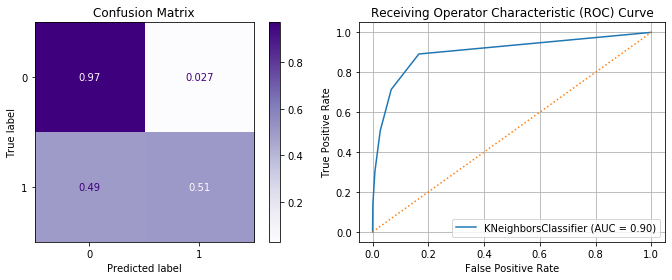

{'0': {'precision': 0.9376820034944671,
  'recall': 0.9726627397674067,
  'f1-score': 0.9548521017125066,
  'support': 6621},
 '1': {'precision': 0.7080645161290322,
  'recall': 0.5063437139561707,
  'f1-score': 0.5904505716207128,
  'support': 867},
 'accuracy': 0.9186698717948718,
 'macro avg': {'precision': 0.8228732598117496,
  'recall': 0.7395032268617887,
  'f1-score': 0.7726513366666097,
  'support': 7488},
 'weighted avg': {'precision': 0.9110956838435814,
  'recall': 0.9186698717948718,
  'f1-score': 0.9126597771145385,
  'support': 7488}}

In [93]:
model_evaluation(knn_pipe, X_test_df, y_test )

### Improve Model

In [64]:
## Create Params grid for n_neighbors
params = {'n_neighbors':list(range(3,27,2))}
params
## Create a GridSearch using F1 as scoring
grid = GridSearchCV(knn_pipe,params,scoring='recall',n_jobs=-1,cv= 3)

In [65]:
## Fit and print best params
grid.fit(X_train_df, y_train)
grid.best_params_

{'n_neighbors': 3}

In [66]:
best_knn = grid.best_estimator_

In [67]:
best_knn.fit(X_train_df,y_train)

KNeighborsClassifier(n_neighbors=3)

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6621
           1       0.73      0.60      0.66       867

    accuracy                           0.93      7488
   macro avg       0.84      0.78      0.81      7488
weighted avg       0.92      0.93      0.92      7488

------------------------------------------------------------




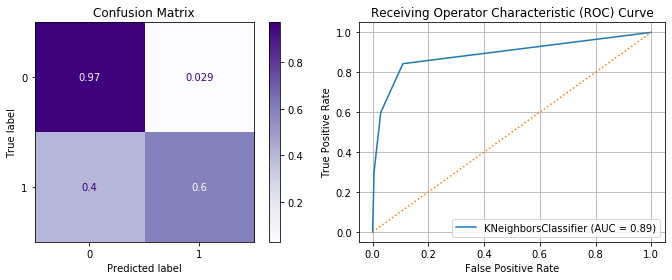

{'0': {'precision': 0.9486346863468634,
  'recall': 0.9706992901374415,
  'f1-score': 0.9595401612421618,
  'support': 6621},
 '1': {'precision': 0.7279102384291725,
  'recall': 0.5986159169550173,
  'f1-score': 0.6569620253164556,
  'support': 867},
 'accuracy': 0.9276175213675214,
 'macro avg': {'precision': 0.838272462388018,
  'recall': 0.7846576035462294,
  'f1-score': 0.8082510932793088,
  'support': 7488},
 'weighted avg': {'precision': 0.9230780495487013,
  'recall': 0.9276175213675214,
  'f1-score': 0.9245060741898665,
  'support': 7488}}

In [92]:
model_evaluation(best_knn, X_test_df,y_test)

# Random Forests Classifier

In [71]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
rfc=RandomForestClassifier(class_weight = 'balanced')
rfc.fit(X_train_df, y_train)

RandomForestClassifier(class_weight='balanced')

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      6621
           1       0.91      0.52      0.66       867

    accuracy                           0.94      7488
   macro avg       0.93      0.75      0.81      7488
weighted avg       0.94      0.94      0.93      7488

------------------------------------------------------------




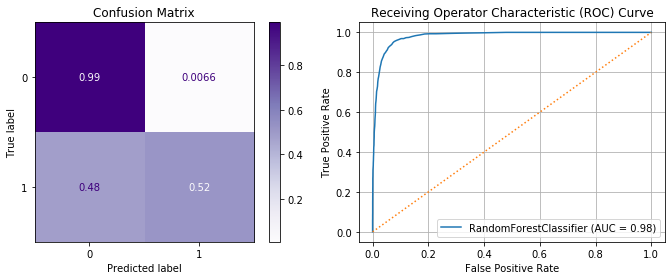

{'0': {'precision': 0.9399742746891525,
  'recall': 0.9933544781755022,
  'f1-score': 0.9659274489646057,
  'support': 6621},
 '1': {'precision': 0.9103869653767821,
  'recall': 0.5155709342560554,
  'f1-score': 0.658321060382916,
  'support': 867},
 'accuracy': 0.938034188034188,
 'macro avg': {'precision': 0.9251806200329673,
  'recall': 0.7544627062157787,
  'f1-score': 0.8121242546737608,
  'support': 7488},
 'weighted avg': {'precision': 0.9365485004939301,
  'recall': 0.938034188034188,
  'f1-score': 0.9303111643892418,
  'support': 7488}}

In [91]:
model_evaluation(rfc, X_test_df, y_test)

Looks like this imbalnced data set is going to be a problem with these models so i will use SMOTE to balance the data set

# SMOTE

In [98]:
from imblearn.over_sampling import SMOTENC



In [105]:
sm = SMOTENC(categorical_features=[15,16,17,18,19], random_state=123, sampling_strategy=.6)
X_trainres, y_trainres = sm.fit_resample(X_train_df, y_train)

In [106]:
from collections import Counter
print("Before SMOTE :" , Counter(y_train))
print("After SMOTE :" , Counter(y_trainres))

Before SMOTE : Counter({0: 15468, 1: 2001})
After SMOTE : Counter({0: 15468, 1: 9280})


In [134]:
rfc_smote=RandomForestClassifier()
rfc_smote.fit(X_trainres, y_trainres)

RandomForestClassifier()

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6621
           1       0.80      0.77      0.78       867

    accuracy                           0.95      7488
   macro avg       0.88      0.87      0.88      7488
weighted avg       0.95      0.95      0.95      7488

------------------------------------------------------------




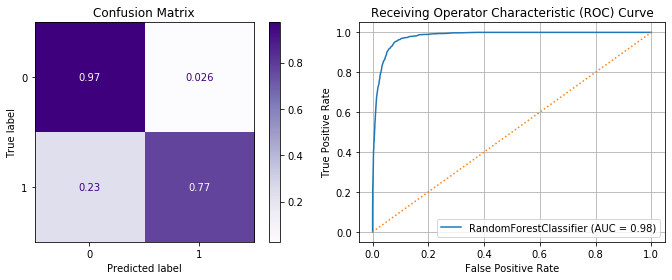

{'0': {'precision': 0.9702121257710246,
  'recall': 0.9740220510496904,
  'f1-score': 0.9721133554416642,
  'support': 6621},
 '1': {'precision': 0.7954815695600476,
  'recall': 0.7716262975778547,
  'f1-score': 0.7833723653395784,
  'support': 867},
 'accuracy': 0.9505876068376068,
 'macro avg': {'precision': 0.882846847665536,
  'recall': 0.8728241743137726,
  'f1-score': 0.8777428603906213,
  'support': 7488},
 'weighted avg': {'precision': 0.9499809035174298,
  'recall': 0.9505876068376068,
  'f1-score': 0.9502599315075686,
  'support': 7488}}

In [109]:
model_evaluation(rfc_smote, X_test_df, y_test)

In [127]:
list(np.arange(.1,1,.1))

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]

In [135]:


## Create Params grid for sampling_strategy
params = {'sampling_strategy':list(np.arange(.1,1,.1))}
params
## Create a GridSearch using F1 as scoring
grid = GridSearchCV(rfc_smote,params,scoring='recall',n_jobs=-1,cv= 3)

In [137]:
## Fit and print best params
grid.fit(X_trainres, y_trainres)
grid.best_index_

ValueError: Invalid parameter sampling_strategy for estimator RandomForestClassifier(). Check the list of available parameters with `estimator.get_params().keys()`.

In [81]:
rfc_importance = pd.Series(rfc.feature_importances_, index = X_train_df.columns)

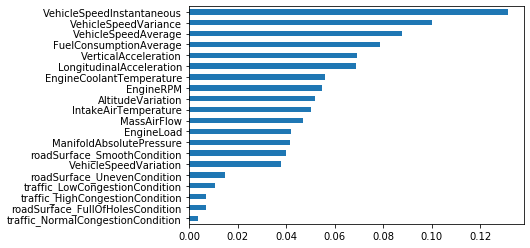

In [83]:
rfc_importance.sort_values().plot(kind ='barh')